In [1]:
import sys
sys.path.insert(0, "../scripts")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from fbprophet import Prophet
import pmdarima as pmd
from rstl import STL
#from decprophet import DecProphet
from decpredict import DecProphet, DecARIMA
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

C:\Users\ariel\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

C:\Users\ariel\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.



In [3]:
plt.rcParams["figure.figsize"] = [16,4]
pd.plotting.register_matplotlib_converters()

In [4]:
def prepare_data(orig_data):
    data = orig_data.copy()
    data.columns = orig_data.columns.str.replace(r"\s\(.*\)", "").str.lower()
    fixed_date = data["date"].str.replace(r"/[0-9]{4}$", "")
    fixed_time = data["time"].str.replace("24:00", "00:00")
    data["ds"] = pd.to_datetime("2019" + "/" + fixed_date + " " + fixed_time, format="%Y/%m/%d %H:%M")
    data.loc[data.time == "24:00", "ds"] = data.loc[data.time == "24:00", "ds"] + pd.Timedelta(pd.offsets.Day(1))
    data = data.drop(columns=["date", "time"])
    data = data[['ds', 'etr', 'ghi', 'dni', 'dhi', 'totcld']]
    data = data.rename(columns={'totcld':'cld'})
    return data

In [5]:
orig_data = pd.read_csv("../data/722287TYA.CSV")

# DecProphet

In [68]:
data = prepare_data(orig_data)

In [69]:
data = pd.get_dummies(data, columns=["cld"], drop_first=True)

In [70]:
data = data.set_index("ds").sort_index()

In [71]:
data["hour"] = data.index.hour
data["day"] = data.index.dayofyear

In [72]:
data.head()

,etr,ghi,dni,dhi,cld_1,cld_2,cld_3,cld_4,cld_5,cld_6,cld_7,cld_8,cld_9,cld_10,hour,day
ds,,,,,,,,,,,,,,,,
2019-01-01 01:00:00,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1
2019-01-01 02:00:00,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,1
2019-01-01 03:00:00,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3,1
2019-01-01 04:00:00,0,0,0,0,0,0,0,0,0,0,0,0,1,0,4,1
2019-01-01 05:00:00,0,0,0,0,0,0,0,0,0,0,0,0,1,0,5,1


In [73]:
train, test = data["2019-01-01":"2019-11-30"].copy(), data["2019-12-01":"2019-12-14"].copy()

In [75]:
train = train.rename(columns={"ghi":"y"}).reset_index()
test = test.rename(columns={"ghi":"y"}).reset_index()

In [47]:
regressors = ['cld_1', 'cld_2', 'cld_3', 'cld_4', 'cld_5', 'cld_6', 'cld_7', 'cld_8', 'cld_9', 'cld_10', "day"]

In [48]:
model = DecProphet(exog=regressors, yearly=True)

In [49]:
model.fit(train)

In [50]:
forecast = model.predict(test)

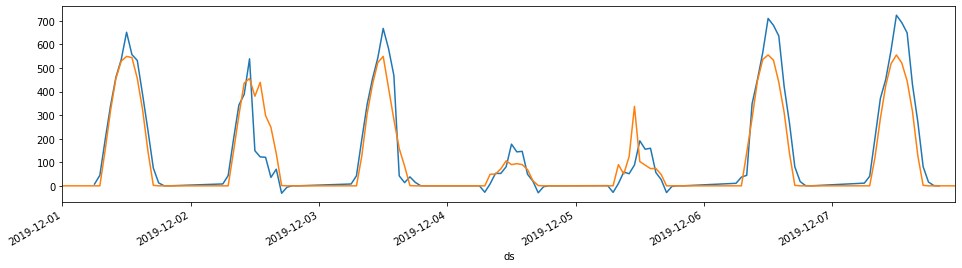

In [51]:
forecast.set_index("ds").yhat.plot()
test.set_index("ds").y.plot()

# Prophet

In [76]:
regressors = ['cld_1', 'cld_2', 'cld_3', 'cld_4', 'cld_5', 'cld_6', 'cld_7', 'cld_8', 'cld_9', 'cld_10', "day", "hour"]

In [77]:
model = Prophet(yearly_seasonality=True, daily_seasonality=True, weekly_seasonality=False)

In [78]:
for reg in regressors:
    model.add_regressor(reg)

In [79]:
model.fit(train)

In [80]:
future = model.make_future_dataframe(len(test), freq="H", include_history=False)

In [81]:
future = future.merge(test[["ds"]+regressors], left_on="ds", right_on="ds")

In [82]:
forecast = model.predict(future)

In [83]:
forecast.loc[forecast.yhat < 0, "yhat"] = 0

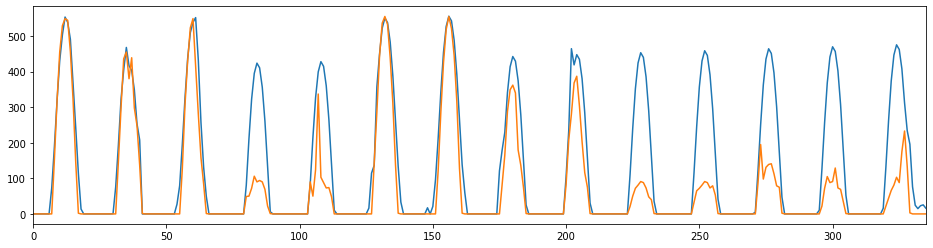

In [84]:
forecast.yhat.plot()
test.y.plot()

# Random Forest

In [6]:
data = prepare_data(orig_data)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


In [7]:
data = data.set_index("ds")

In [8]:
data["hour"] = data.index.hour
data["day"] = data.index.day
data["month"] = data.index.month

In [9]:
data = data.rename(columns={"ghi":"y"})

In [10]:
data

,etr,y,dni,dhi,cld,hour,day,month
ds,,,,,,,,
2019-01-01 01:00:00,0,0,0,0,3,1,1,1
2019-01-01 02:00:00,0,0,0,0,9,2,1,1
2019-01-01 03:00:00,0,0,0,0,9,3,1,1
2019-01-01 04:00:00,0,0,0,0,9,4,1,1
2019-01-01 05:00:00,0,0,0,0,9,5,1,1
...,...,...,...,...,...,...,...,...
2019-12-31 20:00:00,0,0,0,0,10,20,31,12
2019-12-31 21:00:00,0,0,0,0,10,21,31,12
2019-12-31 22:00:00,0,0,0,0,10,22,31,12


In [11]:
train, test = data["2019-01-01":"2019-11-30"].copy(), data["2019-12-01":"2019-12-31"].copy()

In [12]:
X_train, y_train = train[["cld", "hour", "month", "day"]], train["y"]
X_test, y_test = test[["cld", "hour", "month", "day"]], test["y"]

In [13]:
randomforest = RandomForestRegressor(n_estimators=1000)

In [14]:
randomforest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [15]:
forecast = randomforest.predict(X_test)

In [16]:
forecast = pd.Series(forecast, index=y_test.index)

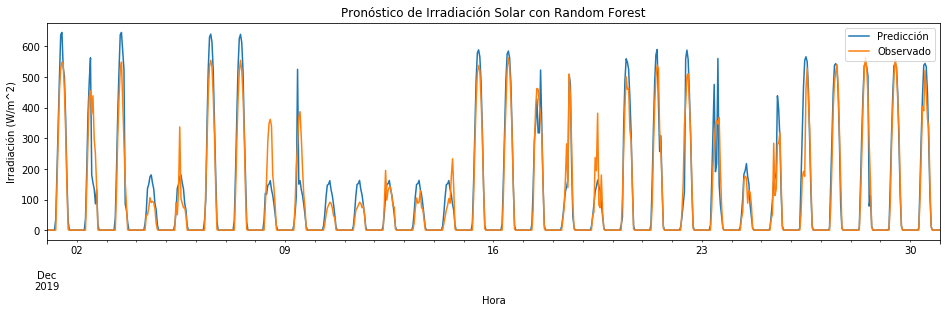

In [20]:
forecast.plot()
y_test.plot(xlim=("2019-12-01", "2019-12-31"));
plt.title("Pronóstico de Irradiación Solar con Random Forest")
plt.xlabel("Hora")
plt.ylabel("Irradiación (W/m^2)")
plt.legend(["Predicción", "Observado"])

# DecARIMA

In [31]:
data = prepare_data(orig_data)

In [32]:
data = data.set_index("ds")

In [33]:
data = data.drop(columns=["etr", "dni", "dhi"])

In [34]:
data = pd.get_dummies(data, columns=["cld"], drop_first=True)

In [35]:
train, test = data["2019-03-01":"2019-04-30"].copy(), data["2019-05-01":"2019-05-07"].copy()

In [36]:
train = train.reset_index()
test = test.reset_index()

In [37]:
regressors = ['cld_1', 'cld_2', 'cld_3', 'cld_4', 'cld_5', 'cld_6', 'cld_7', 'cld_8', 'cld_9', 'cld_10']

In [38]:
model = DecARIMA(endog="ghi", exog=regressors, ds="ds", time_range=range(4,21))

In [39]:
model.fit(train)

C:\Users\ariel\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:253: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.



In [40]:
forecast = model.predict(test)

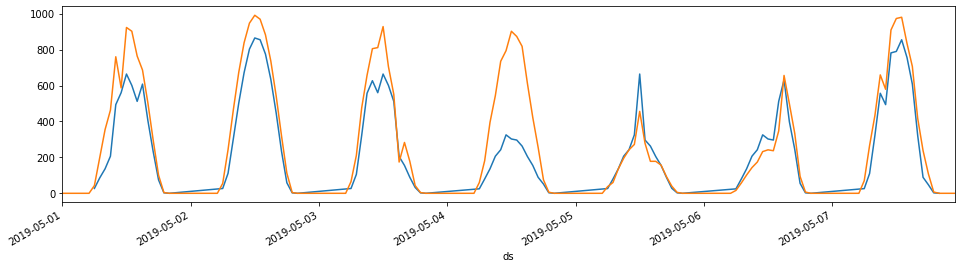

In [41]:
forecast.plot()
test.set_index("ds").ghi.plot()

# Scraps

In [54]:
X_train = train[regressors + ["hour", "day"]].to_numpy()
X_test = test[regressors + ["hour", "day"]].to_numpy()

In [55]:
y_train = train.y.to_numpy()
y_test = test.y.to_numpy()

In [128]:
ridge = Ridge(alpha=0.001)

In [129]:
ridge.fit(X_train, y_train)

Ridge(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [130]:
forecast = ridge.predict(X_test)

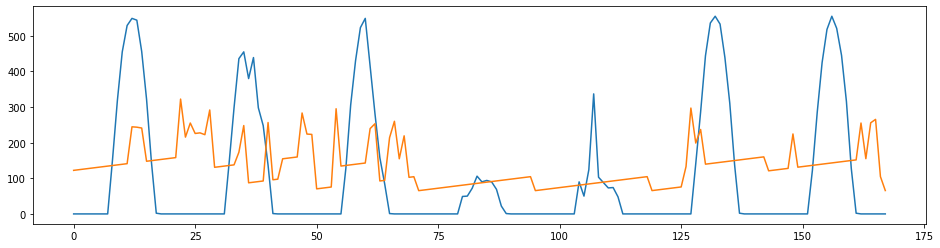

In [131]:
plt.plot(y_test)
plt.plot(forecast)

In [64]:
randomforest = RandomForestRegressor(n_estimators=100)

In [65]:
randomforest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [66]:
forecast = randomforest.predict(X_test)

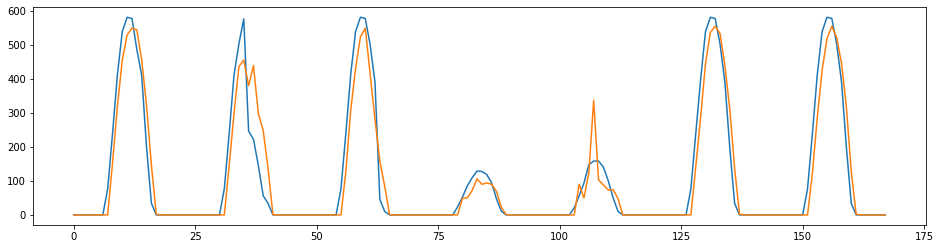

In [67]:
plt.plot(forecast)
plt.plot(y_test)

In [105]:
svr = SVR(kernel="rbf", C=1000)

In [106]:
svr.fit(X_train, y_train)

C:\Users\ariel\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.



SVR(C=1000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [107]:
forecast = svr.predict(X_test)

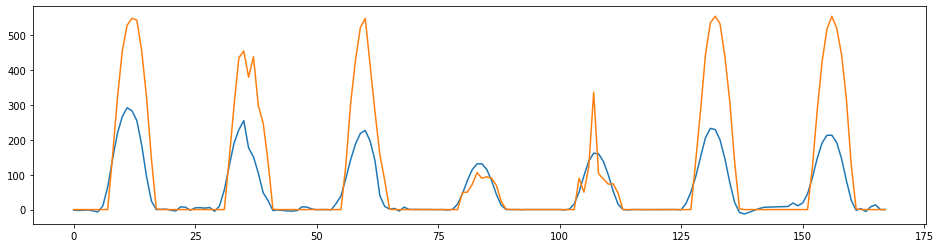

In [108]:
plt.plot(forecast)
plt.plot(y_test)

In [111]:
linear_regression = LinearRegression()

In [112]:
linear_regression.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [114]:
forecast = linear_regression.predict(X_test)

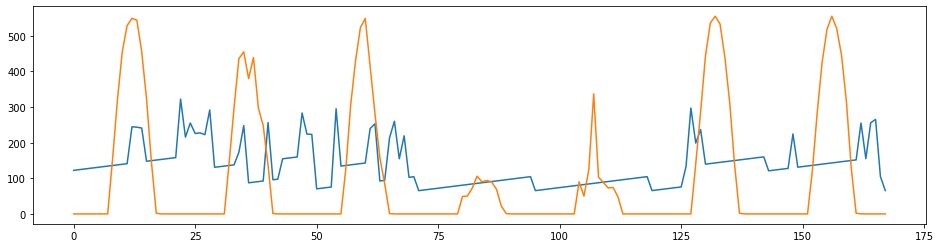

In [115]:
plt.plot(forecast)
plt.plot(y_test)

In [172]:
kn = KNeighborsRegressor(n_neighbors=5, weights="distance", )

In [167]:
kn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                    weights='distance')

In [168]:
forecast = kn.predict(X_test)

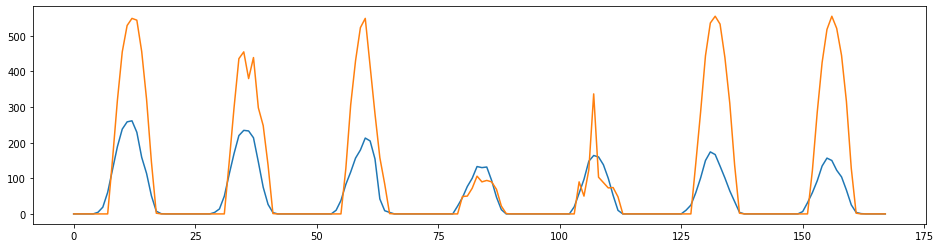

In [171]:
plt.plot(forecast)
plt.plot(y_test)

In [295]:
april = data[data.index.month == 4].copy()

In [ ]:
train, test = april[:"2019-04-23"].copy(), april["2019-04-24":].copy()

In [282]:
stl_dec = STL(train.ghi, freq=24, s_window="periodic")

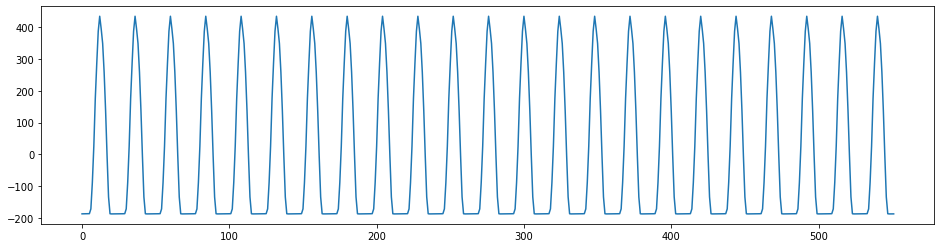

In [283]:
plt.plot(stl_dec.seasonal)

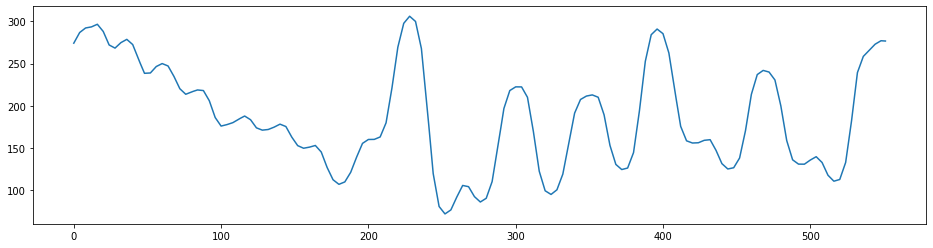

In [284]:
plt.plot(stl_dec.trend)

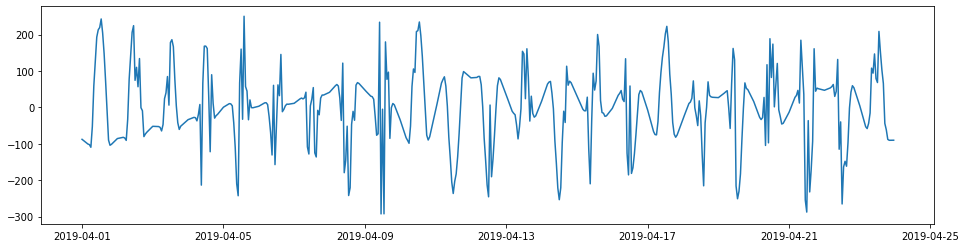

In [285]:
plt.plot(stl_dec.remainder)

In [286]:
y = pd.Series(stl_dec.trend, index=train.index)

In [293]:
train

,index,ds,etr,y,dni,dhi,cld_1,cld_2,cld_3,cld_4,cld_5,cld_6,cld_7,cld_8,cld_9,cld_10
0,0,2019-04-01 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1,2019-04-01 01:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,2019-04-01 02:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,2019-04-01 03:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,2019-04-01 04:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547,547,2019-04-23 19:00:00,12,2,0,2,0,0,1,0,0,0,0,0,0,0
548,548,2019-04-23 20:00:00,0,0,0,0,0,1,0,0,0,0,0,0,0,0
549,549,2019-04-23 21:00:00,0,0,0,0,0,0,1,0,0,0,0,0,0,0
550,550,2019-04-23 22:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [230]:
train["y"] = y

In [232]:
train.head()

,etr,ghi,dni,dhi,cld_1,cld_2,cld_3,cld_4,cld_5,cld_6,cld_7,cld_8,cld_9,cld_10,y
ds,,,,,,,,,,,,,,,
2019-04-01 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,1,274.248945
2019-04-01 01:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,277.408016
2019-04-01 02:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,280.567088
2019-04-01 03:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,283.726159
2019-04-01 04:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,286.885230


In [233]:
train = train.reset_index()
test = test.reset_index()

In [261]:
m = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False)

In [262]:
# for reg in regressors:
#     m.add_regressor(reg)

In [263]:
m.fit(train)

In [264]:
future = m.make_future_dataframe(periods=len(test), freq="H", include_history=True)

In [265]:
exogs = pd.concat([train[regressors], test[regressors]], ignore_index=True)
future = pd.merge(future, exogs, left_index=True, right_index=True)

In [266]:
future

,ds,cld_1,cld_2,cld_3,cld_4,cld_5,cld_6,cld_7,cld_8,cld_9,cld_10
0,2019-04-01 00:00:00,0,0,0,0,0,0,0,0,0,1
1,2019-04-01 01:00:00,0,0,0,0,0,0,0,0,0,0
2,2019-04-01 02:00:00,0,0,0,0,0,0,0,0,0,0
3,2019-04-01 03:00:00,0,0,0,0,0,0,0,0,0,0
4,2019-04-01 04:00:00,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
715,2019-04-30 19:00:00,0,0,0,0,0,0,0,0,1,0
716,2019-04-30 20:00:00,0,0,0,0,0,0,0,0,1,0
717,2019-04-30 21:00:00,0,0,0,0,0,0,0,0,1,0
718,2019-04-30 22:00:00,0,0,1,0,0,0,0,0,0,0


In [267]:
forecast = m.predict(future)

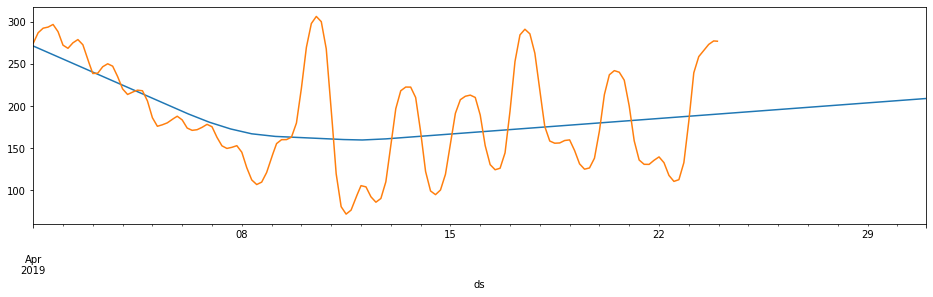

In [268]:
forecast.set_index("ds").yhat.plot()
#test.set_index("ds").y.plot()
train.set_index("ds").y.plot()

In [144]:
april_seasonal = pd.Series(stl_dec.seasonal, index=april.index)
res = april_seasonal + forecast.set_index("ds").yhat

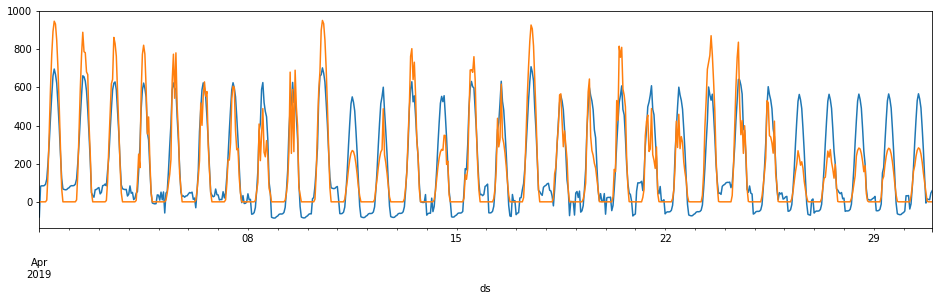

In [147]:
res.plot()
april.ghi.plot()

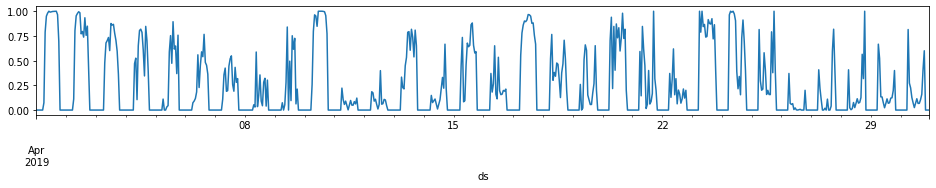

In [9]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_ghi_list = []
for k in range(24):
    ghi_k = data.loc[(data.index.hour == k) & (data.index.month == 4), "ghi"]
    values = ghi_k.to_numpy().reshape(-1, 1)
    index = ghi_k.index
    scaled_values = scaler.fit_transform(values.reshape(-1,1))
    scaled_ghi_k = pd.Series(scaled_values.reshape(-1), index=index)
    scaled_ghi_list.append(scaled_ghi_k)
scaled_data = pd.concat(scaled_ghi_list)
scaled_data = scaled_data.sort_index()
df = data[data.index.month == 4].copy()
df["y"] = scaled_data
#df["y"] = scaled_data.diff()
df["y"].plot(figsize=(16,2))
#(1/10*data.loc[data.index.month == 4, "cld"]).plot()

In [133]:
df = pd.get_dummies(df, columns=["cld"], drop_first=True)

In [134]:
train, test = df.loc["2019-04-01":"2019-04-23"], df.loc["2019-04-24":"2019-04-30"]

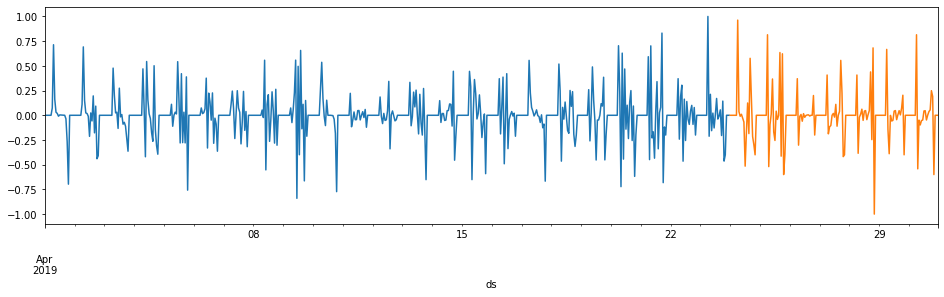

In [135]:
train.y.plot()
test.y.plot()

In [136]:
train = train.reset_index()
test = test.reset_index()

In [145]:
m = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False)

In [146]:
regressors = ["cld_1", "cld_2", "cld_3", "cld_6", "cld_9", "cld_10"]

In [147]:
for reg in regressors:
    m.add_regressor(reg)

In [148]:
m.fit(train)

In [149]:
future = m.make_future_dataframe(periods=len(test), freq="H", include_history=False)

In [150]:
future = future.merge(test[regressors], left_index=True, right_index=True)

In [151]:
forecast = m.predict(future)

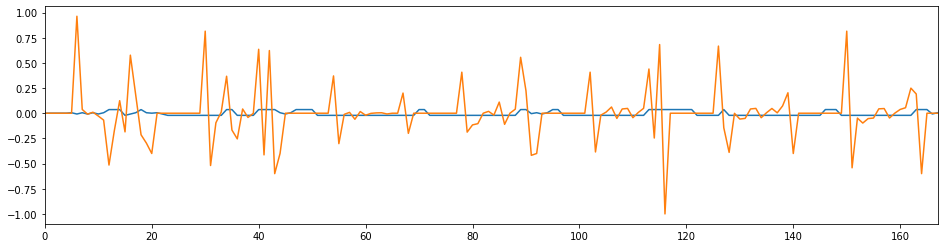

In [152]:
forecast.yhat.plot()
test.y.plot()

In [83]:
test

,ds,etr,ghi,dni,dhi,y,cld_1,cld_2,cld_3,cld_6,cld_9,cld_10
0,2019-04-24 00:00:00,0,0,0,0,0.0,0,0,0,0,0,0
1,2019-04-24 01:00:00,0,0,0,0,0.0,0,0,0,0,0,0
2,2019-04-24 02:00:00,0,0,0,0,0.0,0,0,0,0,0,0
3,2019-04-24 03:00:00,0,0,0,0,0.0,0,0,0,0,0,0
4,2019-04-24 04:00:00,0,0,0,0,0.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
163,2019-04-30 19:00:00,20,3,0,3,0.6,0,0,0,0,1,0
164,2019-04-30 20:00:00,0,0,0,0,0.0,0,0,0,0,1,0
165,2019-04-30 21:00:00,0,0,0,0,0.0,0,0,0,0,1,0
166,2019-04-30 22:00:00,0,0,0,0,0.0,0,0,1,0,0,0


In [33]:
df.loc[~df.index.hour.isin(range(9,18))] = np.nan

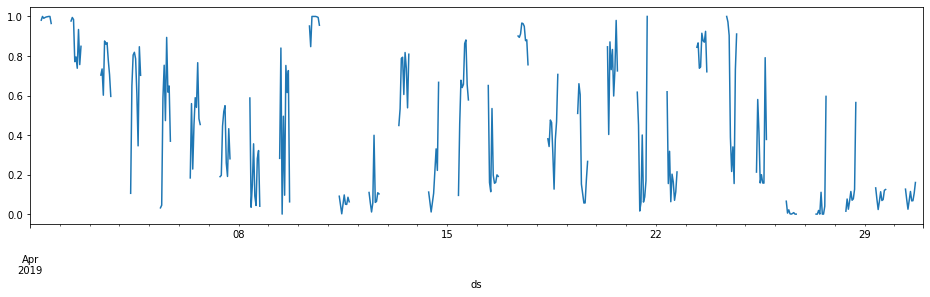

In [34]:
df.plot()

In [12]:
scaled_data[scaled_data.index.hour.isin(range())]

ds
2019-04-01 00:00:00    0.0
2019-04-02 00:00:00    0.0
2019-04-03 00:00:00    0.0
2019-04-04 00:00:00    0.0
2019-04-05 00:00:00    0.0
                      ... 
2019-04-26 23:00:00    0.0
2019-04-27 23:00:00    0.0
2019-04-28 23:00:00    0.0
2019-04-29 23:00:00    0.0
2019-04-30 23:00:00    0.0
Length: 334, dtype: float64

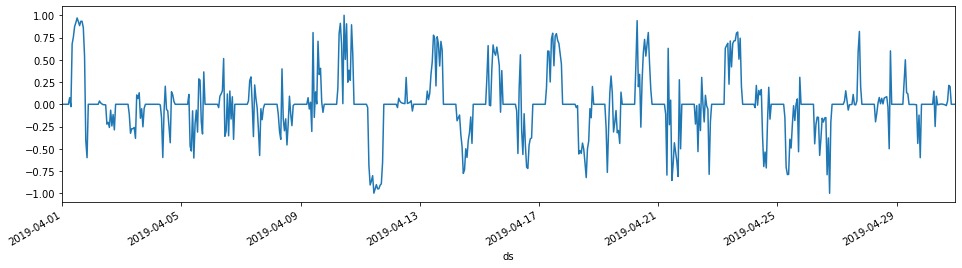

In [299]:
scaled_data.diff().plot()

In [310]:
scaled_diff = scaled_data.diff().diff()

In [318]:
scaled_diff.name = "y"

In [313]:
cld = data.loc[data.index.month == 4, "cld"]

In [320]:
df = pd.merge(scaled_diff, cld, left_index=True, right_index=True)

In [387]:
df = df.sort_index()

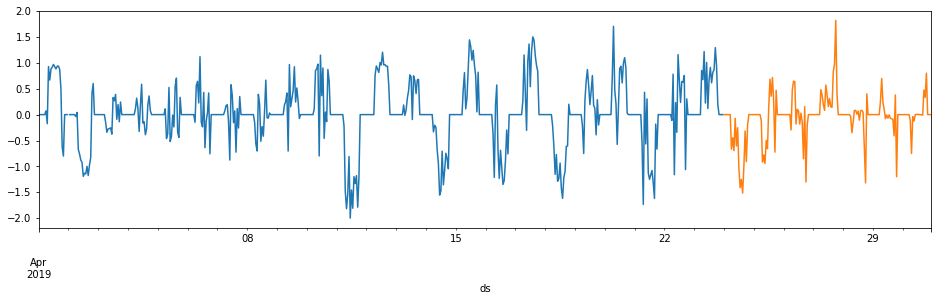

In [389]:
train.y.plot()
test.y.plot()

In [400]:
train = train.dropna()
test = test.dropna()

In [423]:
model_arima = pm.auto_arima(y=train[["y"]], exogenous=train[["cld"]], trace=True)

Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=591.097, BIC=621.266, Fit time=0.575 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=959.858, BIC=972.788, Fit time=0.156 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=629.596, BIC=646.836, Fit time=0.209 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=779.202, BIC=796.442, Fit time=0.272 seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=590.831, BIC=616.690, Fit time=0.385 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=588.967, BIC=610.516, Fit time=0.207 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=590.832, BIC=616.691, Fit time=0.386 seconds
Total fit time: 2.200 seconds


In [416]:
forecast = model_arima.predict(len(test), exogenous=test[["cld"]])

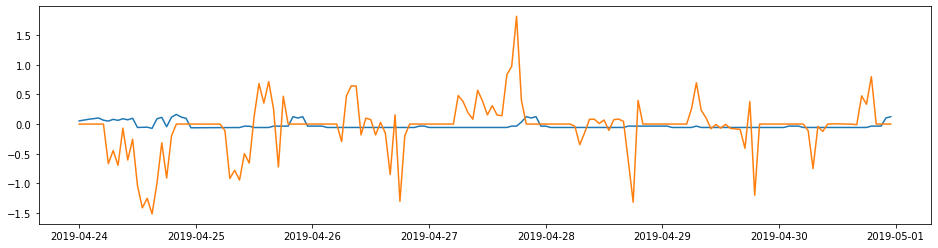

In [419]:
plt.plot(pd.Series(forecast, index=test.index))
plt.plot(test.y)

In [ ]:
pd.Series

In [340]:
train = train.reset_index()

In [341]:
test = test.reset_index()

In [342]:
train

,ds,y,cld
0,2019-04-01 00:00:00,NaN,10
1,2019-04-02 00:00:00,NaN,0
2,2019-04-03 00:00:00,0.0,0
3,2019-04-04 00:00:00,0.0,2
4,2019-04-05 00:00:00,0.0,3
...,...,...,...
547,2019-04-19 23:00:00,0.0,3
548,2019-04-20 23:00:00,0.0,10
549,2019-04-21 23:00:00,0.0,9
550,2019-04-22 23:00:00,0.0,10


In [343]:
test

,ds,y,cld
0,2019-04-24 00:00:00,0.0,0
1,2019-04-25 00:00:00,0.0,10
2,2019-04-26 00:00:00,0.0,9
3,2019-04-27 00:00:00,0.0,10
4,2019-04-28 00:00:00,0.0,9
...,...,...,...
163,2019-04-26 23:00:00,0.0,9
164,2019-04-27 23:00:00,0.0,9
165,2019-04-28 23:00:00,0.0,9
166,2019-04-29 23:00:00,0.0,10


In [344]:
m = Prophet()

In [345]:
m.add_regressor("cld")

In [346]:
m.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [355]:
future = m.make_future_dataframe(len(test), freq="H", include_history=False)

In [356]:
future = future.merge(test, left_on="ds", right_on="ds")
future = future.drop(columns="y")

In [359]:
forecast = m.predict(future)

In [368]:
test = test.set_index("ds").sort_index()

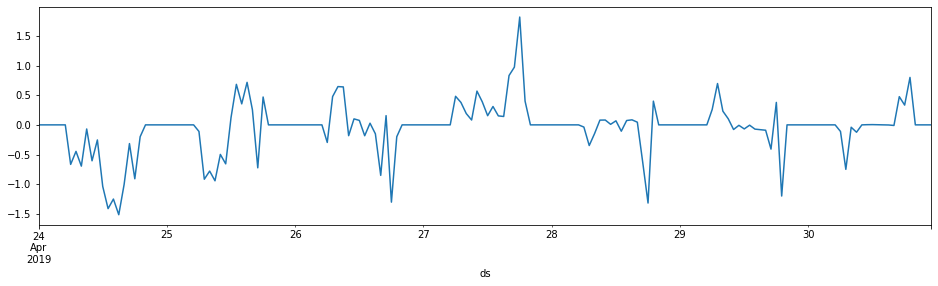

In [370]:
test.y.plot()

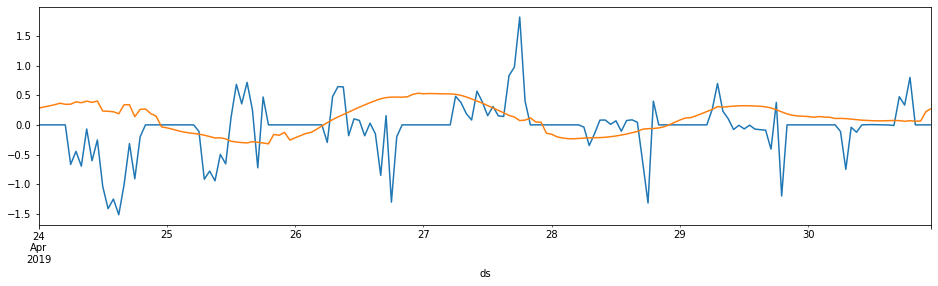

In [372]:
test.y.plot()
forecast.set_index("ds").yhat.plot()

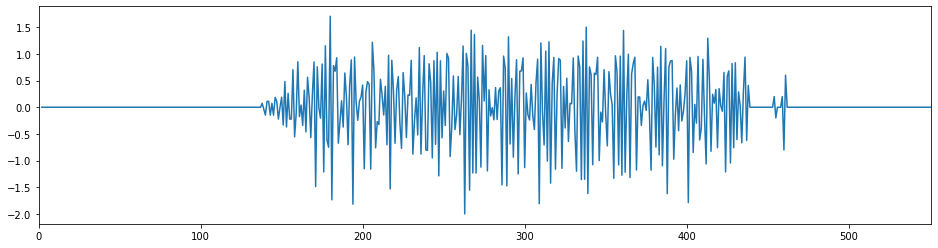

In [373]:
train.y.plot()

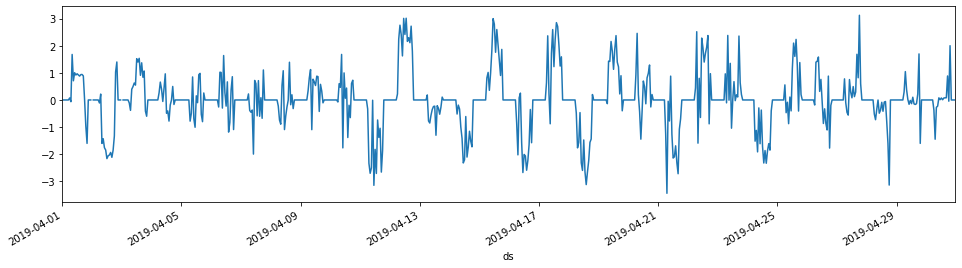

In [296]:
scaled_data.diff(1).diff(1).diff(1).plot()

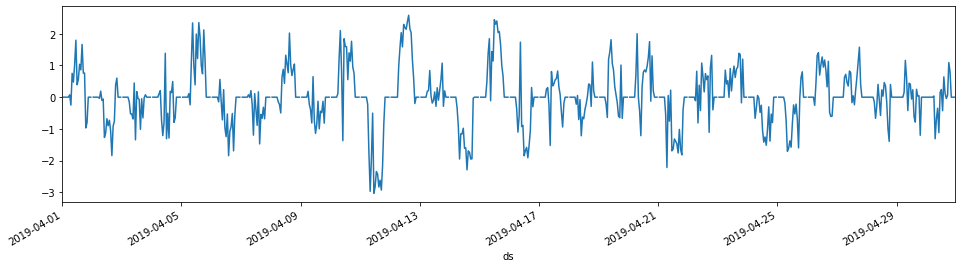

In [295]:
scaled_data.diff(24).diff(1).).plot()

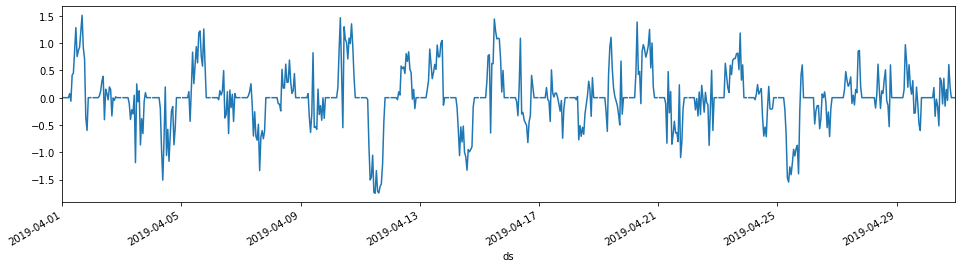

In [291]:
scaled_data.diff(1).diff(24).plot()

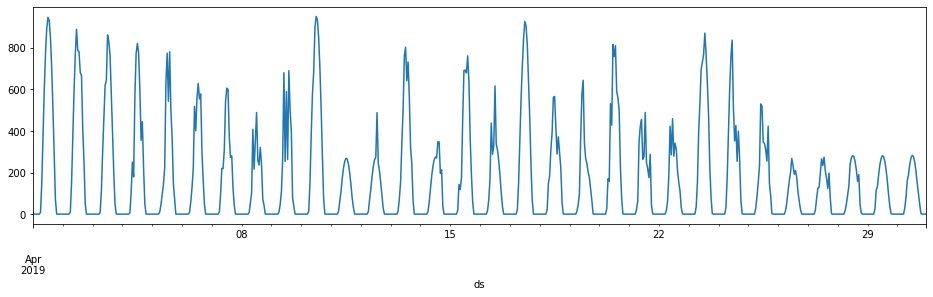

In [280]:
data.loc[(data.index.month == 4), "ghi"].plot()

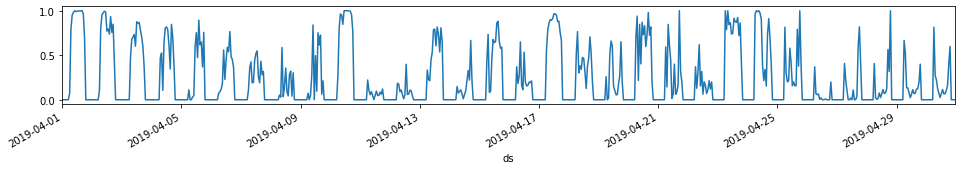

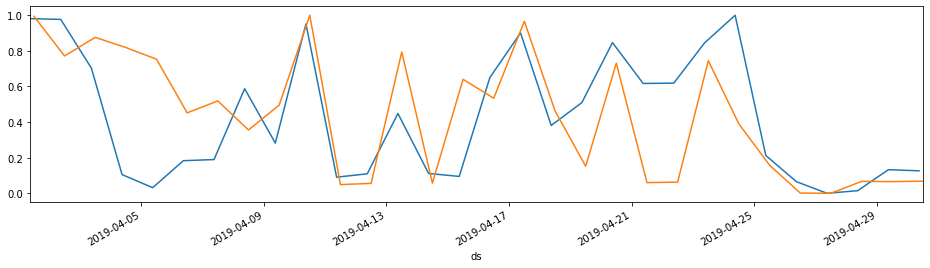

In [245]:
scaled_ghi_list[9].plot()
scaled_ghi_list[12].plot()

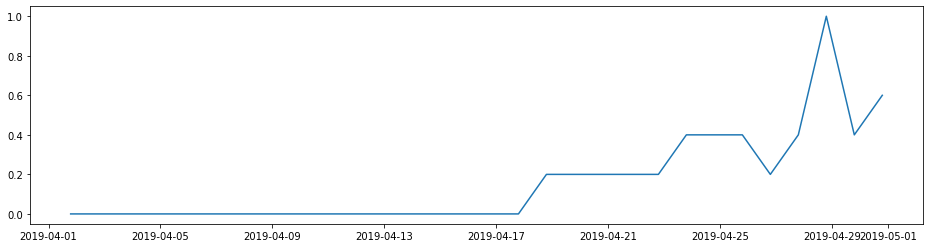

In [278]:
ds = scaled_ghi_list[19]
plt.plot(ds[ds.index.month == 4])

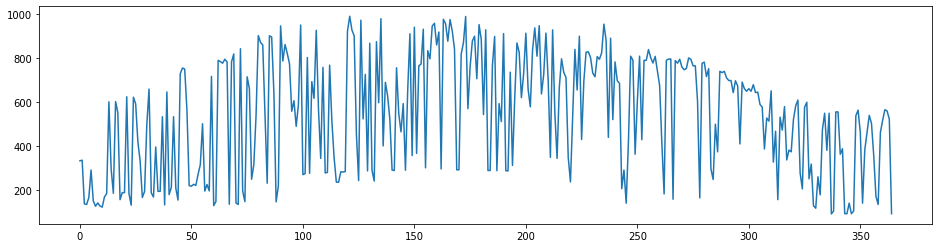

In [308]:
plt.plot(scaler.inverse_transform(scaled12))

In [304]:
scaled12 = scaler.fit_transform(ghi12)

In [222]:
scaled12.reshape(-1)

array([0.26859046, 0.27192009, 0.05105438, 0.04772475, 0.08213097,
       0.22197558, 0.0654828 , 0.03884573, 0.0554939 , 0.0399556 ,
       0.03440622, 0.0854606 , 0.10321865, 0.56714761, 0.22863485,
       0.10432852, 0.56825749, 0.5127636 , 0.07214206, 0.10765816,
       0.10765816, 0.59267481, 0.10321865, 0.04439512, 0.59045505,
       0.55715871, 0.36403996, 0.26859046, 0.08324084, 0.11320755,
       0.45061043, 0.63152053, 0.10654828, 0.0854606 , 0.33851276,
       0.11431743, 0.11431743, 0.49167592, 0.04550499, 0.61709212,
       0.09766926, 0.13429523, 0.49167592, 0.13096559, 0.06992231,
       0.70921199, 0.73806881, 0.73251942, 0.52497225, 0.14317425,
       0.13984462, 0.14983352, 0.14428413, 0.2008879 , 0.24861265,
       0.45615982, 0.1154273 , 0.14872364, 0.11653718, 0.69589345,
       0.04217536, 0.06215316, 0.77691454, 0.77025527, 0.76248613,
       0.78246393, 0.76914539, 0.04883463, 0.76914539, 0.809101  ,
       0.0554939 , 0.04772475, 0.83573807, 0.1154273 , 0.06215

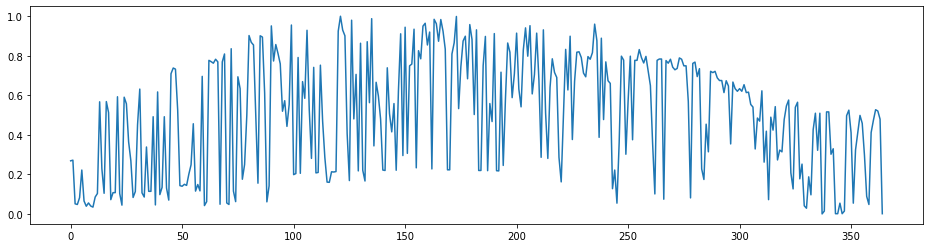

In [220]:
plt.plot(scaled12)

In [197]:
ghi12 = ghi[ghi.index.hour == 12].to_numpy().reshape(-1,1)

In [198]:
ghi12.shape

(365, 1)

In [192]:
scaled12 = scaler.fit_transform(ghi[ghi.index.hour == 12])

ValueError: Expected 2D array, got 1D array instead:
array=[332. 335. 136. 133. 164. 290. 149. 125. 140. 126. 121. 167. 183. 601.
 296. 184. 602. 552. 155. 187. 187. 624. 183. 130. 622. 592. 418. 332.
 165. 192. 496. 659. 186. 167. 395. 193. 193. 533. 131. 646. 178. 211.
 533. 208. 153. 729. 755. 750. 563. 219. 216. 225. 220. 271. 314. 501.
 194. 224. 195. 717. 128. 146. 790. 784. 777. 795. 783. 134. 783. 819.
 140. 133. 843. 194. 146. 715. 661. 248. 315. 539. 903. 872. 860. 551.
 230. 902. 896. 641. 145. 218. 947. 787. 862. 821. 774. 558. 606. 489.
 589. 951. 269. 274. 803. 275. 693. 617. 927. 566. 343. 758. 277. 279.
 768. 513. 347. 235. 234. 282. 281. 283. 923. 991. 928. 902. 456. 242.
 973. 523. 726. 286. 868. 289. 240. 875. 597. 980. 400. 690. 628. 522.
 290. 288. 756. 547. 464. 593. 289. 651. 911. 356. 941. 366. 765. 773.
 932. 300. 834. 797. 946. 959. 860. 919. 295. 977. 957. 877. 976. 923.
 841. 291. 291. 819. 870. 990. 570. 761. 878. 900. 706. 953. 885. 543.
 929. 288. 288. 766. 899. 287. 593. 511. 912. 287. 286. 736. 311. 616.
 869. 827. 620. 729. 914. 659. 578. 837. 938. 809. 948. 637. 725. 914.
 701. 348. 929. 550. 343. 667. 797. 735. 712. 348. 236. 540. 840. 655.
 900. 429. 695. 827. 829. 803. 732. 715. 807. 795. 825. 955. 880. 439.
 891. 520. 783. 697. 685. 205. 290. 139. 417. 809. 791. 362. 604. 809.
 428. 790. 790. 839. 802. 778. 808. 742. 675. 410. 181. 790. 796. 796.
 157. 789. 777. 795. 759. 747. 753. 801. 795. 765. 765. 602. 163. 776.
 782. 716. 752. 295. 247. 499. 373. 740. 734. 740. 710. 698. 698. 643.
 697. 673. 409. 691. 661. 649. 661. 649. 679. 643. 645. 589. 577. 386.
 527. 513. 651. 326. 467. 155. 531. 472. 579. 336. 381. 373. 520. 582.
 609. 277. 204. 576. 599. 250. 317. 127. 116. 259. 177. 474. 549. 380.
 549.  90. 103. 555. 555. 362. 387.  91.  91. 139.  91. 103. 538. 563.
 460. 139. 382. 460. 539. 503. 358. 170. 133. 461. 516. 565. 559. 522.
  91.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

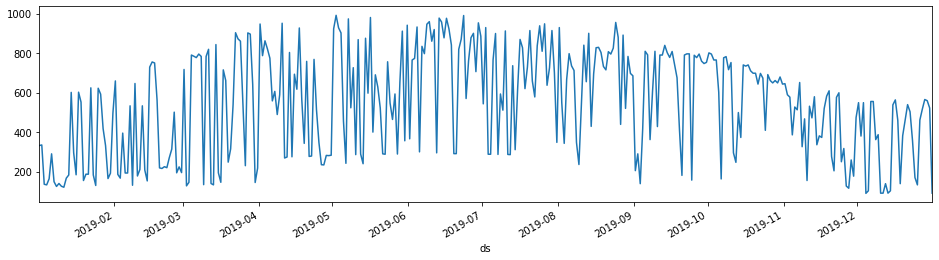

In [188]:
ghi[ghi.index.hour == 12].plot()

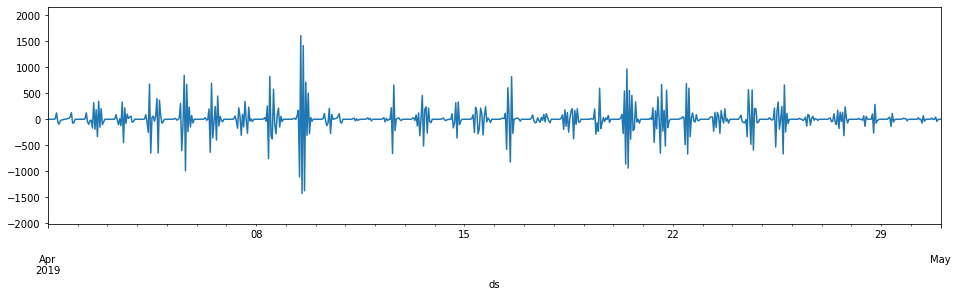

In [178]:
data.ghi.diff().diff().diff().dropna().plot(xlim=("2019-04","2019-05"))

In [169]:
relevant = data.copy()
relevant.loc[~data.index.hour.isin(range(10,15))] = np.nan

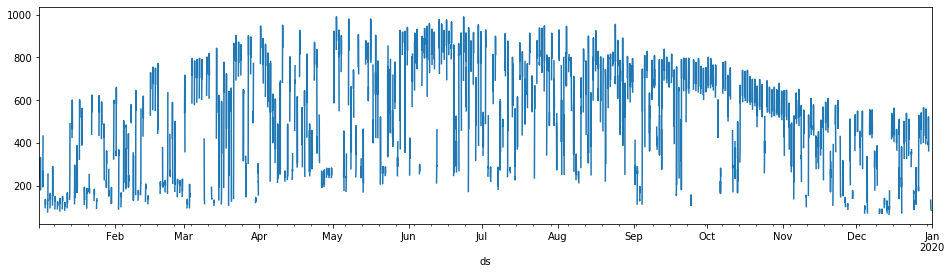

In [172]:
relevant.ghi.plot()

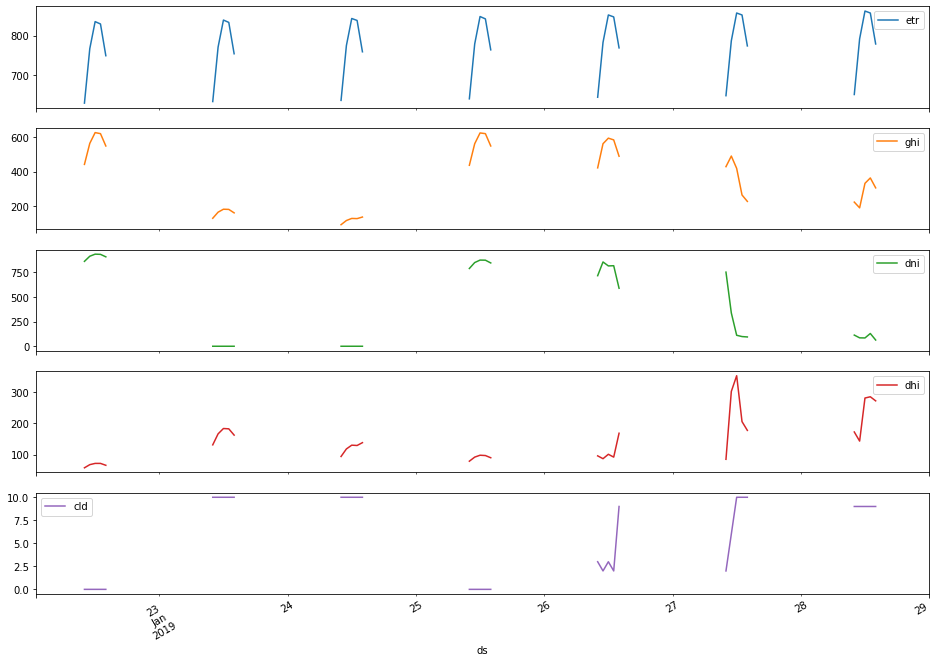

In [175]:
k = 4
d = 7
relevant.iloc[(k-1)*d*24:k*d*24].plot(subplots=True, figsize=(16,12));

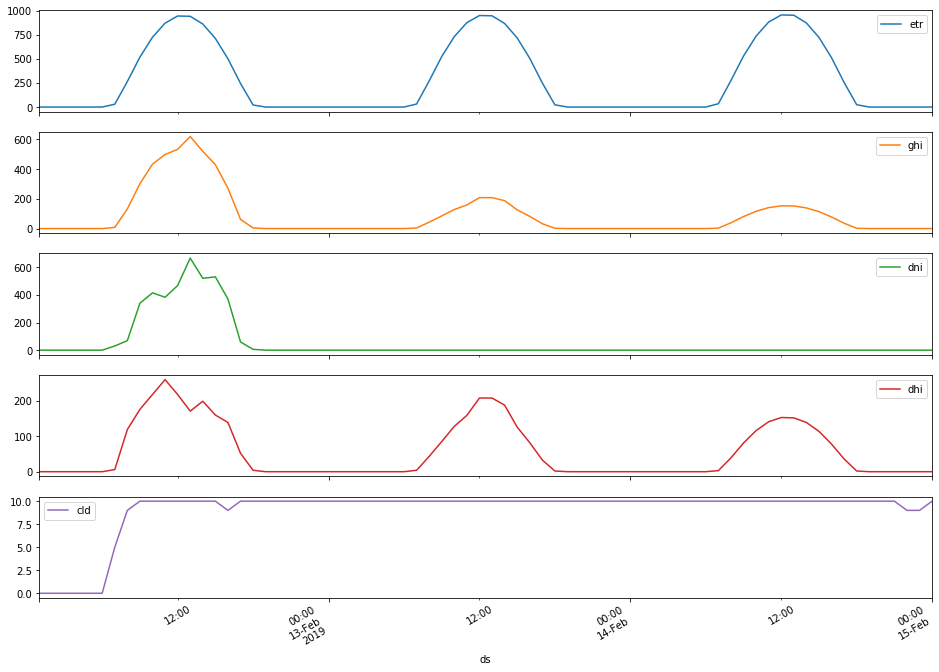

In [157]:
k = 15
d = 3
data.iloc[(k-1)*d*24:k*d*24].plot(subplots=True, figsize=(16,12));

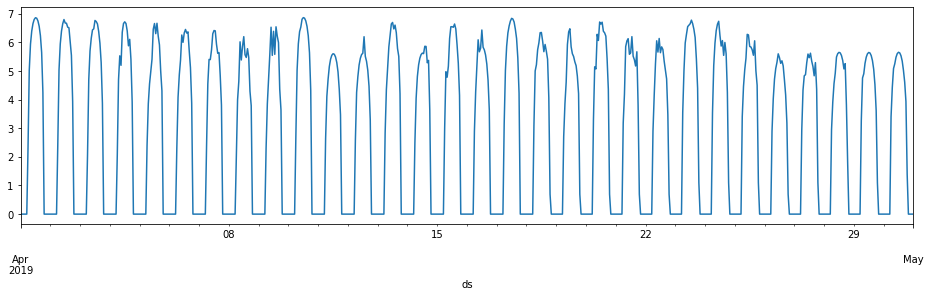

In [168]:
np.log(data.ghi+1).plot(xlim=("2019-04","2019-05"))

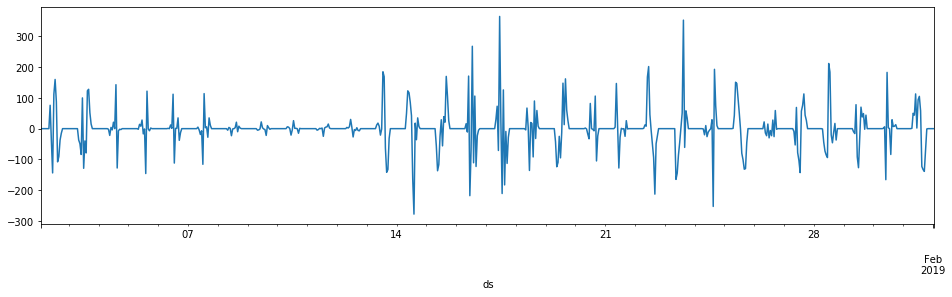

In [149]:
k = 1
d = 30
data_s = data.ghi.diff(24).diff(1).dropna()
data_s.iloc[(k-1)*d*24:k*d*24].plot()

In [ ]:
data_s = data.ghi.diff(1).dropna()
data_s.iloc[(k-1)*30*24:k*30*24].plot()

In [ ]:
k=1
data_dd = data.ghi.diff(1).diff(1).dropna()
data_d.iloc[(k-1)*30*24:k*30*24].plot()

In [17]:
ghi = data.ghi

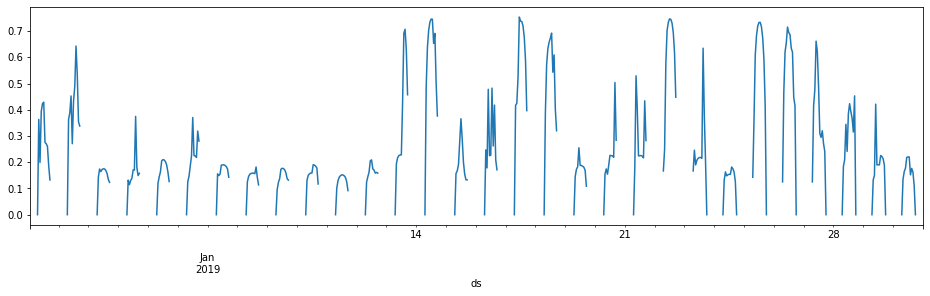

In [131]:
adj = data.ghi / data.etr
adj.iloc[:24*30].plot()

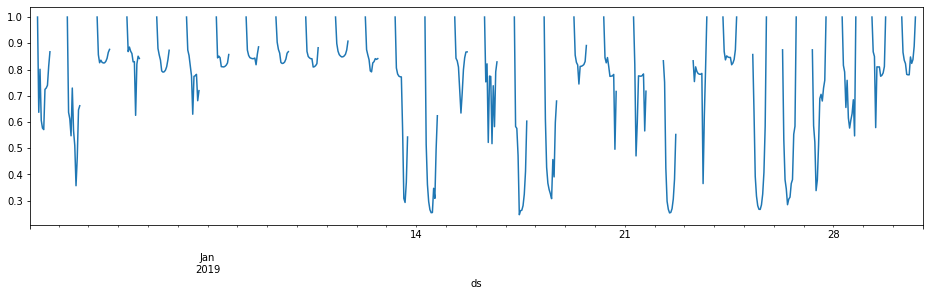

In [126]:
adj = (data.ghi - data.etr).abs() / data.etr
adj.iloc[:24*30].plot()

In [109]:
classical_decomposition = seasonal_decompose(ghi+1, model="multiplicative")

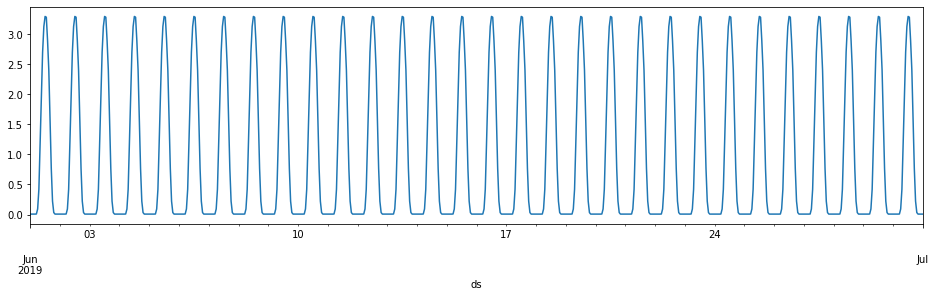

In [110]:
classical_decomposition.seasonal.plot(xlim=("2019-06","2019-07"))

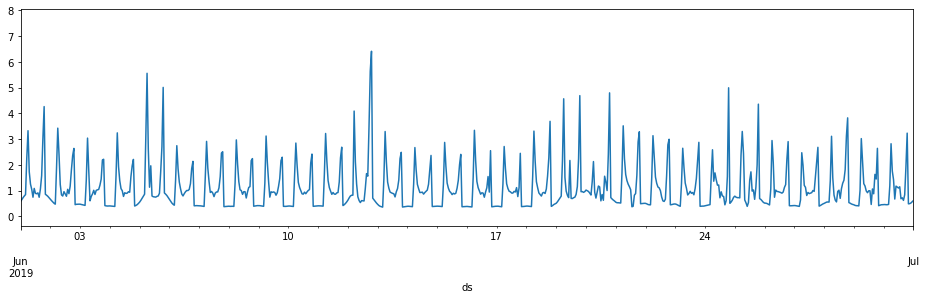

In [111]:
classical_decomposition.resid.plot(xlim=("2019-06","2019-07"))

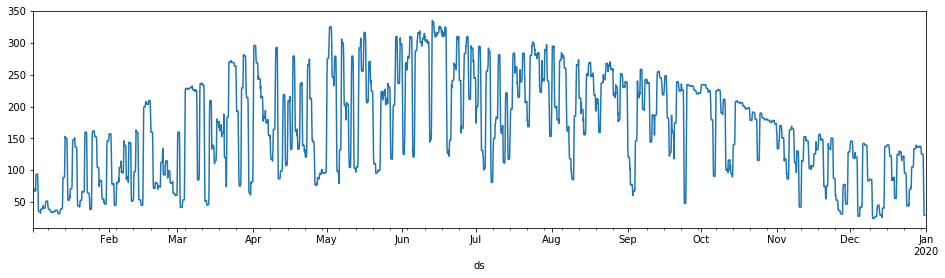

In [112]:
classical_decomposition.trend.plot()

In [106]:
stl_decomposition = STL(ghi[ghi.index.month == 4], period=24, seasonal=999, robust=True).fit(inner_iter=2, outer_iter=20)

In [113]:
stl_decomposition = STL(ghi, period=24, seasonal=99, robust=True).fit(inner_iter=2, outer_iter=20)

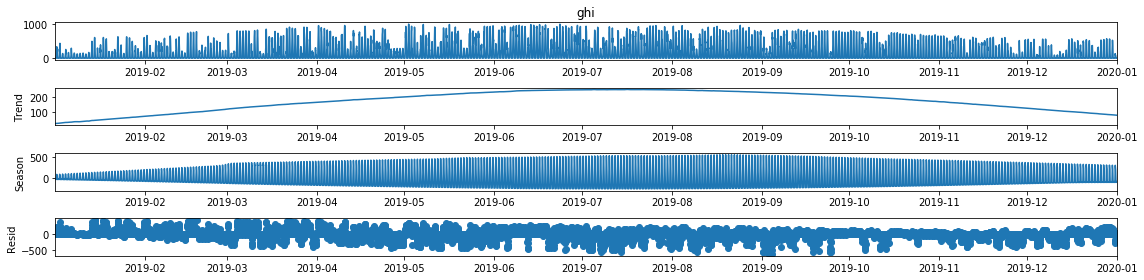

In [114]:
stl_decomposition.plot();

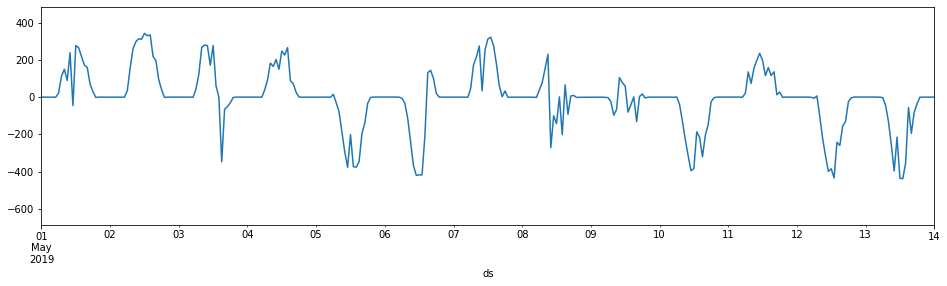

In [118]:
stl_decomposition.resid.plot(xlim=("2019-05-01","2019-05-14"))

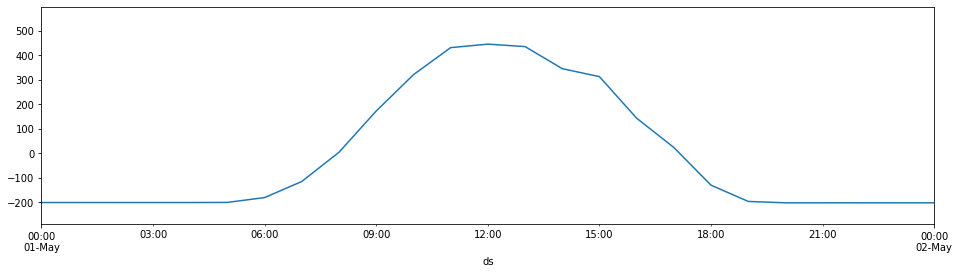

In [116]:
stl_decomposition.seasonal.plot(xlim=("2019-05-01","2019-05-02"))

In [48]:
seasonal = stl_decomposition.seasonal

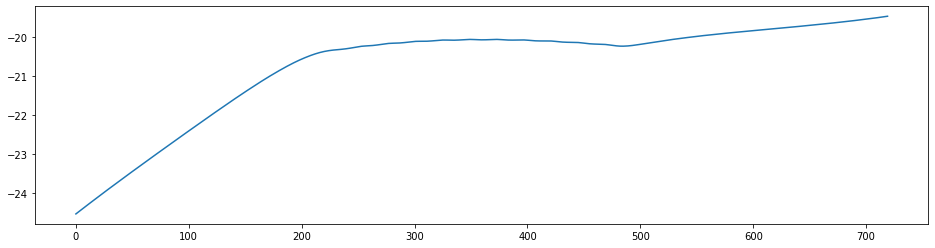

In [57]:
plt.plot(lowess(endog=seasonal, exog=range(len(seasonal)))[:,1])

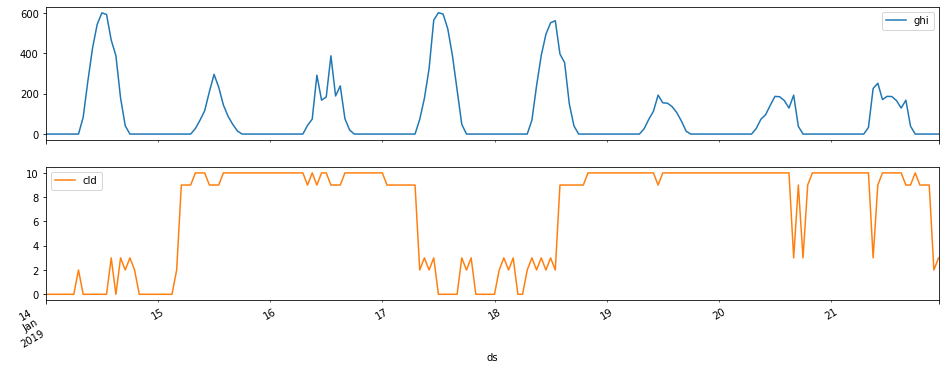

In [279]:
data.loc["2019-01-14":"2019-01-21"].plot(y=["ghi", "cld"], subplots=True, figsize=(16,6));

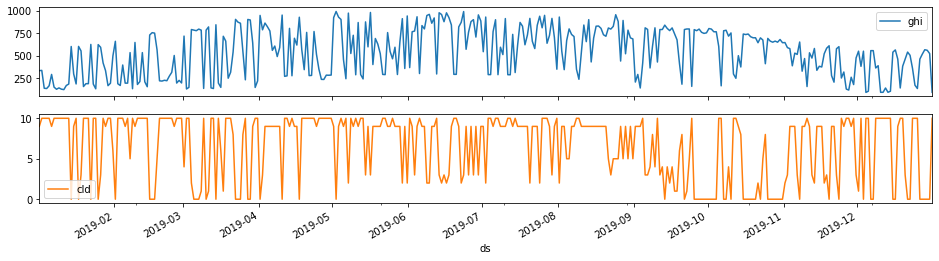

In [309]:
data.loc[data.index.hour == 12, ["ghi", "cld"]].plot(subplots=True);

In [310]:
ghi = data.loc[, "ghi"]

In [318]:
data.cld

ds
2019-01-01 01:00:00     3
2019-01-01 02:00:00     9
2019-01-01 03:00:00     9
2019-01-01 04:00:00     9
2019-01-01 05:00:00     9
                       ..
2019-12-31 20:00:00    10
2019-12-31 21:00:00    10
2019-12-31 22:00:00    10
2019-12-31 23:00:00    10
2020-01-01 00:00:00     9
Name: cld, Length: 8760, dtype: int64

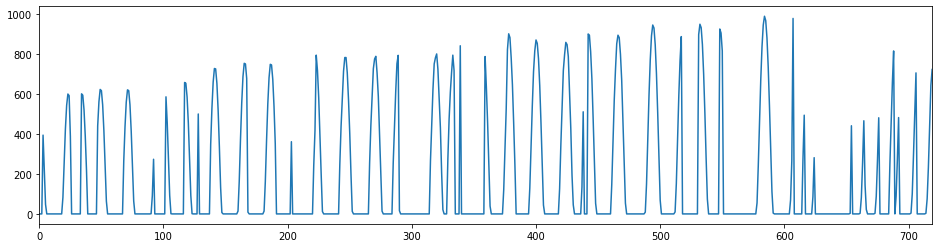

In [315]:
ghi.reset_index().iloc[:24*30].ghi.plot()

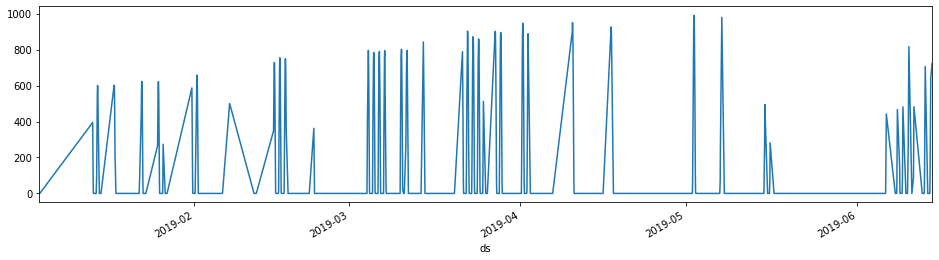

In [311]:
ghi.iloc[:24*30].plot()

In [302]:
y = lowess(endog=ghi, exog=range(len(ghi)))[:,1]

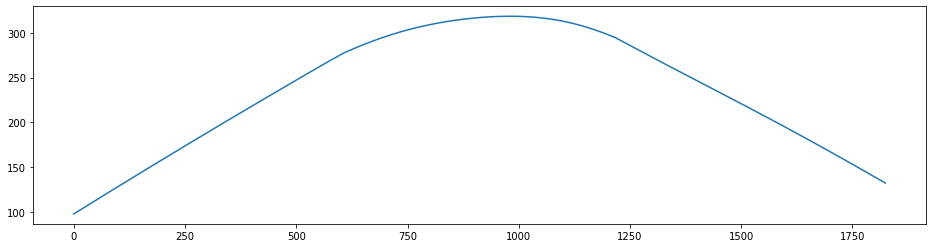

In [303]:
plt.plot(y)

In [290]:
plt

<module 'matplotlib.pyplot' from 'C:\\Users\\ariel\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>